<a href="https://colab.research.google.com/github/Singular-Brain/bindsnet/blob/master/saunders2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [1]:
!pip install -q git+https://github.com/Singular-Brain/bindsnet

     |████████████████████████████████| 120 kB 13.7 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 280 kB 25.0 MB/s 
     |████████████████████████████████| 28.5 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!wget https://data.deepai.org/mnist.zip
!mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
!unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

--2021-08-03 13:51:28--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  71.4MB/s    in 0.2s    

2021-08-03 13:51:29 (71.4 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz  


In [37]:
from bindsnet.network.nodes import Nodes
import os
import torch
import torchvision
import numpy as np
import argparse
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm.notebook import tqdm

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import LocalConnection, Connection
from bindsnet.network.monitors import Monitor, AbstractMonitor, TensorBoardMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET 
from bindsnet.learning.reward import DynamicDopamineInjection
from bindsnet.utils import get_square_assignments, get_square_weights
from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels, update_ngram_scores, ngram
from bindsnet.analysis.plotting import (
    plot_input,
    plot_assignments,
    plot_performance,
    plot_weights,
    plot_spikes,
    plot_voltages,
)

## Sets up Gpu use


In [38]:
gpu = True
seed = 2045
train = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)


Running on Device =  cuda


# Design network

## Hyparparameters


In [39]:
device_id = 0
# target_classes = (0,1)
target_classes = None
if target_classes:
    n_classes = len(target_classes)
else:
    n_classes = 10

seed = 2045 # The Singularity is Near!

dt = 1.0
time = 250
crop_size = 20
C = 100
K = 12
S = 4
inh_factor = 17.5
norm_factor = 0.2
inp_lr = 1e-2
out_lr = 1e-4
intensity = 127.5
wmin = 0
wmax = 1

compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

## Architecture

In [40]:
network = Network(dt = dt)

### input
inp = Input(shape= [1,20,20], traces=True)

### output
out = AdaptiveLIFNodes(shape= [C, compute_size(crop_size, K, S), compute_size(crop_size, K, S)], traces=True)

### Locally connected connection
LC = LocalConnection(inp, out, K, S, C, nu = [inp_lr, out_lr], update_rule = PostPre, wmin = wmin, wmax= wmax, norm=norm_factor)

### output recurrent inhibition conncection
w = -inh_factor * (
            torch.ones(out.n, out.n)
            - torch.diag(torch.ones(out.n))
        )
recurrent_connection = Connection(
    source=out,
    target=out,
    w=w,
    wmin=-inh_factor,
    wmax=0, 
)

network.add_layer(inp, "input")
network.add_layer(out, "output")
network.add_connection(LC, "input", "output")
network.add_connection(recurrent_connection, "output", "output")


# Voltage recording for excitatory and inhibitory layers.
output_monitor = Monitor(network.layers["output"], ["v"], time=time, device=device)
tensorboard = TensorBoardMonitor(network, time = time)
network.add_monitor(output_monitor, name="output")
network.add_monitor(tensorboard, name="tensorboard")

print(device)
if gpu:
    network.to("cuda")

cuda


In [41]:
assignments = -torch.ones(out.n, device=device)
proportions = torch.zeros((out.n, n_classes), device=device)
rates = torch.zeros((out.n, n_classes), device=device)

# Load Dataset

In [42]:
!git clone https://github.com/Singular-Brain/bindsnet/

fatal: destination path 'bindsnet' already exists and is not an empty directory.


In [43]:
# mask = torch.from_numpy(np.load(f'bindsnet/mask_{target_classes[0]}_{target_classes[1]}.npz')['arr_0'])

In [44]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source, mask = None):
        if mask is not None:
            self.mask = mask
        else:
            self.mask = torch.tensor([1 if data_source[i]['label'] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [45]:

# Load MNIST data.
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Lambda(lambda x: x * intensity),
        transforms.CenterCrop(crop_size)]
    ),
)

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         sampler = ClassSelector(
                                                target_classes = target_classes,
                                                data_source = dataset,
                                                mask = mask,
                                                ) if target_classes else None
                                         )

# Load test dataset
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Lambda(lambda x: x * intensity),
        transforms.CenterCrop(crop_size)]
    ),
)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                         sampler = ClassSelector(
                                                target_classes = target_classes,
                                                data_source = test_dataset,
                                                mask = mask,
                                                ) if target_classes else None
                                         )

# Evaluation Utils

In [46]:
def evaluate(network, val_loader, assignments):
    correct = 0
    false = 0
    spikes_val = {}

    network.train = False
    for (i, datum) in enumerate(val_loader):
        if i > n_val:
            break

        image = datum["encoded_image"]
        label = datum["label"]

        # Run the network on the input.
        if gpu:
            inputs = {"input": image.cuda().view(time, 1, 1, 20, 20)}
        else:
            inputs = {"input": image.view(time, 1, 1, 20, 20)}
        network.run(inputs=inputs, time=time, labels=label)

        # Record the spikes
        output_spikes = spikes["output"].get("s")
            # Record the spikes

        spike_record = output_spikes.view(time, -1).squeeze()

        ## All activity
        # Get network predictions.
        prediction_label = all_activity(
            spikes=spike_record, assignments=assignments, n_labels=n_classes
        )

        # # Update ngram scores
        # predicted_label = ngram(spikes=output_spikes.view(1, time, out.n), ngram_scores=ngram_scores, n_labels=n_classes, n=2)


        print("\rvalidation sample, predicted_label:",
          predicted_label.item(), 'GT:', label.item(),
          end = '')

        if predicted_label == label:
            correct+=1
        else:
            false+=1
    network.train = True
    val_acc = 100 * correct/(correct + false)
    return val_acc

# Train

In [51]:
# Train the network.
print("Begin training.\n")
n_train = 500
#n_test = 100
n_val = 100
val_interval = 100
ngram_scores = {}
for k in range(100):
    for i in range(3):
        for j in range(3):
            ngram_scores[(k, i, j)] = torch.zeros(1,250)

correct = 0
false = 0

spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

val_acc = 0.0

pbar = tqdm(total=n_train)
network.reset_state_variables()
for (i, datum) in enumerate(dataloader):
    if i > n_train:
        break

    image = datum["encoded_image"]
    label = datum["label"]

    # Run the network on the input.
    if gpu:
        inputs = {"input": image.cuda().view(time, 1, 1, 20, 20)}
    else:
        inputs = {"input": image.view(time, 1, 1, 20, 20)}
    network.run(inputs=inputs, time=time, labels = label)

    # Get voltage recording.
    out_voltage = output_monitor.get("v")
    tensorboard.update(step= i)

    # Record the spikes
    output_spikes = spikes["output"].get("s")
    spike_record = output_spikes.view(time, -1).squeeze()
    print(spike_record.shape)

    ## All activity
    # Get network predictions.
    prediction_label = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )


    # Assign labels to excitatory layer neurons.
    assignments, proportions, rates = assign_labels(
        spikes=spike_record,
        labels=label,
        n_labels=n_classes,
        rates=rates,
    )

    # # Update ngram scores
    # ngram_scores=update_ngram_scores(spikes=output_spikes.view(1, time, out.n), n_labels=n_classes, n=2, labels=label, ngram_scores=ngram_scores)

    # predicted_label = ngram(spikes=output_spikes.view(1, time, out.n), ngram_scores=ngram_scores, n_labels=n_classes, n=2)

    print("\rpredicted_label:",
          predicted_label.item(), 'GT:', label.item(),
          end = '')

    if  i % val_interval == 0 and i!=0:
        if i != n_train:
            correct = 0
            false = 0
        val_acc = evaluate(network, val_loader, ngram_scores)


    if predicted_label == label:
        correct+=1
    else:
        false+=1
        
    acc = 100 * correct/(correct + false)
    network.reset_state_variables()  # Reset state variables.
    
    pbar.set_description_str("Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
    pbar.update()

Begin training.



  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([250, 900])


IndexError: ignored

In [ ]:
import matplotlib.pyplot as plt


plt.plot(output_spikes.sum(-1)[:,0])
plt.plot(output_spikes.sum(-1)[:,1])

plt.plot(reward_monitor.get())
plt.show()

In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

# Kernel 

In [ ]:
from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

In [ ]:
class AbstractKernel(ABC):
	r"""Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
	"""
	def __init__(self, kernel_size: Union[int, Tuple[int, int]]):
    """
    Instantiates a ``Filter Kernel`` object.

    :param kernel_size: Horizontal and vertical size of convolutional kernels.
    """
		self.kernel_size = _pair(kenel_size)

	def __call__(self):
		pass


In [ ]:
class DoG_Kernel(AbstractKernel):
	r"""Generates DoG filter kernels.
	"""
	def __init__(self, 
                 kernel_size: Union[int, Tuple[int, int]], 
                 sigma1 : float,
                 sigma2 : float):
        """
		:param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
		:param sigma1 : The sigma parameter for the first Gaussian function.
		:param sigma2 : The sigma parameter for the second Gaussian function.
		"""
        super(DoG_Kernel, self).__init__(kernel_size)
		self.sigma1 = sigma1
		self.sigma2 = sigma2

	# returns a 2d tensor corresponding to the requested DoG filter
	def __call__(self):
		k = self.kernel_size//2
		x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
		a = 1.0 / (2 * math.pi)
		prod = x*x + y*y
		f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
		f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
		dog = a * (f1-f2)
		dog_mean = np.mean(dog)
		dog = dog - dog_mean
		dog_max = np.max(dog)
		dog = dog / dog_max
		dog_tensor = torch.from_numpy(dog)
		return dog_tensor.float()

# Kasif

Running on Device =  cuda

Begin training.

Progress: 0 / 1 (0.0010 seconds)













  0%|          | 0/60000 [00:00<?, ?it/s]

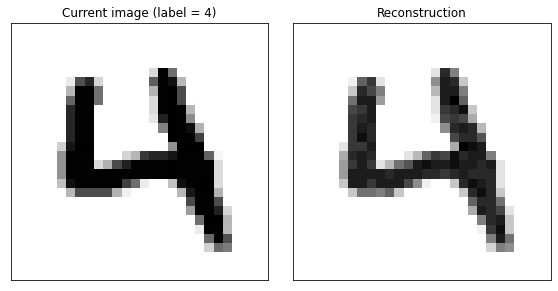

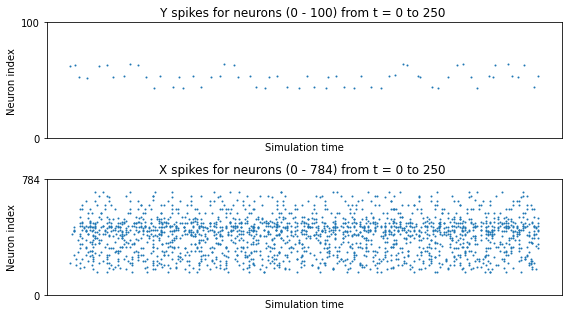

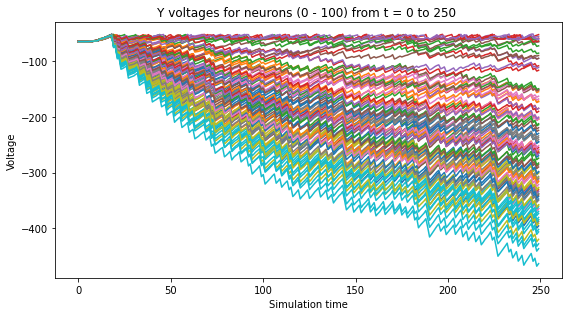

Streaming output truncated to the last 5000 lines.









Train progress:   0%|          | 27/60000 [00:08<4:44:51,  3.51it/s]










Train progress:   0%|          | 27/60000 [00:09<4:44:51,  3.51it/s]










Train progress:   0%|          | 28/60000 [00:09<4:45:05,  3.51it/s]










Train progress:   0%|          | 28/60000 [00:09<4:45:05,  3.51it/s]










Train progress:   0%|          | 29/60000 [00:09<4:43:00,  3.53it/s]










Train progress:   0%|          | 29/60000 [00:09<4:43:00,  3.53it/s]










Train progress:   0%|          | 30/60000 [00:09<4:39:44,  3.57it/s]










Train progress:   0%|          | 30/60000 [00:10<4:39:44,  3.57it/s]










Train progress:   0%|          | 31/60000 [00:10<4:42:14,  3.54it/s]










Train progress:   0%|          | 31/60000 [00:10<4:42:14,  3.54it/s]










Train progress:   0%|          | 32/60000 [00:10<4:39:39,  3.57it/s]










Train progress:   0%|          | 32/60000 [00:10<4:39:39,  3.57it/s]





All activity accuracy: 11.20 (last), 11.20 (average), 11.20 (best)
Proportion weighting accuracy: 11.20 (last), 11.20 (average), 11.20 (best)



<Figure size 432x288 with 0 Axes>












Train progress:   0%|          | 250/60000 [01:14<4:46:44,  3.47it/s]










Train progress:   0%|          | 251/60000 [01:14<8:54:20,  1.86it/s]










Train progress:   0%|          | 251/60000 [01:15<8:54:20,  1.86it/s]










Train progress:   0%|          | 252/60000 [01:15<7:41:37,  2.16it/s]










Train progress:   0%|          | 252/60000 [01:15<7:41:37,  2.16it/s]










Train progress:   0%|          | 253/60000 [01:15<6:45:58,  2.45it/s]










Train progress:   0%|          | 253/60000 [01:15<6:45:58,  2.45it/s]










Train progress:   0%|          | 254/60000 [01:15<6:08:37,  2.70it/s]










Train progress:   0%|          | 254/60000 [01:16<6:08:37,  2.70it/s]










Train progress:   0%|          | 255/60000 [01:16<5:40:04,  2.93it/s]










Train progress:   0%|          | 255/60000 [01:16<5:40:04,  2.93it/s]










Train progress:   0%|          | 256/60000 [01:16<5:24:57,  3.06it/s]










Train progress:   0%|        

KeyboardInterrupt: ignored

In [59]:
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm import tqdm

from time import time as t

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder, poisson
from bindsnet.models import IncreasingInhibitionNetwork
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_weights, get_square_assignments
from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_weights,
    plot_assignments,
    plot_performance,
    plot_voltages,
)

seed = 0
n_neurons=100
n_epochs=1
n_test=10000
n_train=60000
n_workers=-1
theta_plus=0.05
time=250
dt=1.0
intensity=64
progress_interval=10
update_interval=250
update_inhibation_weights=500
plot_interval=250
gpu=True
plot=True

# Sets up Gpu use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

# Determines number of workers to use
if n_workers == -1:
    n_workers = 0  # torch.cuda.is_available() * 4 * torch.cuda.device_count()

n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
start_intensity = intensity

# Build network.
network = IncreasingInhibitionNetwork(
    n_input=784,
    n_neurons=n_neurons,
    start_inhib=10,
    max_inhib=-40.0,
    theta_plus=0.05,
    tc_theta_decay=1e7,
    inpt_shape=(1, 28, 28),
    nu=(1e-4, 1e-2),
)

network.to(device)

# Load MNIST data.
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Record spikes during the simulation.
spike_record = torch.zeros((update_interval, int(time / dt), n_neurons), device=device)

# Neuron assignments and spike proportions.
n_classes = 10
assignments = -torch.ones(n_neurons, device=device)
proportions = torch.zeros((n_neurons, n_classes), device=device)
rates = torch.zeros((n_neurons, n_classes), device=device)

# Sequence of accuracy estimates.
accuracy = {"all": [], "proportion": []}

# Voltage recording for excitatory and inhibitory layers.
som_voltage_monitor = Monitor(
    network.layers["Y"], ["v"], time=int(time / dt), device=device
)
network.add_monitor(som_voltage_monitor, name="som_voltage")

# Set up monitors for spikes and voltages
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(
        network.layers[layer], state_vars=["s"], time=int(time / dt), device=device
    )
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(
        network.layers[layer], state_vars=["v"], time=int(time / dt), device=device
    )
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None
save_weights_fn = "plots/weights/weights.png"
save_performance_fn = "plots/performance/performance.png"
save_assaiments_fn = "plots/assaiments/assaiments.png"

directorys = ["plots", "plots/weights", "plots/performance", "plots/assaiments"]
for directory in directorys:
    if not os.path.exists(directory):
        os.makedirs(directory)

# diagonal weights for increassing the inhibitiosn
weights_mask = (1 - torch.diag(torch.ones(n_neurons))).to(device)

# Train the network.
print("\nBegin training.\n")
start = t()

for epoch in range(n_epochs):
    labels = []

    if epoch % progress_interval == 0:
        print("Progress: %d / %d (%.4f seconds)" % (epoch, n_epochs, t() - start))
        start = t()

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=gpu
    )

    pbar = tqdm(total=n_train)
    for step, batch in enumerate(dataloader):
        if step == n_train:
            break

        # Get next input sample.
        inputs = {
            "X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28).to(device)
        }

        if step > 0:
            if step % update_inhibation_weights == 0:
                if step % (update_inhibation_weights * 10) == 0:
                    network.Y_to_Y.w -= weights_mask * 50
                else:
                    # Inhibit the connection even more
                    # network.Y_to_Y.w -= weights_mask * network.Y_to_Y.w.abs()*0.2
                    network.Y_to_Y.w -= weights_mask * 0.5

            if step % update_interval == 0:
                # Convert the array of labels into a tensor
                label_tensor = torch.tensor(labels, device=device)

                # Get network predictions.
                all_activity_pred = all_activity(
                    spikes=spike_record, assignments=assignments, n_labels=n_classes
                )
                proportion_pred = proportion_weighting(
                    spikes=spike_record,
                    assignments=assignments,
                    proportions=proportions,
                    n_labels=n_classes,
                )

                # Compute network accuracy according to available classification strategies.
                accuracy["all"].append(
                    100
                    * torch.sum(label_tensor.long() == all_activity_pred).item()
                    / len(label_tensor)
                )
                accuracy["proportion"].append(
                    100
                    * torch.sum(label_tensor.long() == proportion_pred).item()
                    / len(label_tensor)
                )

                tqdm.write(
                    "\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
                    % (
                        accuracy["all"][-1],
                        np.mean(accuracy["all"]),
                        np.max(accuracy["all"]),
                    )
                )
                tqdm.write(
                    "Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f"
                    " (best)\n"
                    % (
                        accuracy["proportion"][-1],
                        np.mean(accuracy["proportion"]),
                        np.max(accuracy["proportion"]),
                    )
                )

                # Assign labels to excitatory layer neurons.
                assignments, proportions, rates = assign_labels(
                    spikes=spike_record,
                    labels=label_tensor,
                    n_labels=n_classes,
                    rates=rates,
                )

                labels = []

        labels.append(batch["label"])

        temp_spikes = 0
        factor = 1.2
        for retry in range(5):
            # Run the network on the input.
            network.run(inputs=inputs, time=time, input_time_dim=1)

            # Get spikes from the network
            temp_spikes = spikes["Y"].get("s").squeeze()

            if temp_spikes.sum().sum() < 2:
                inputs["X"] *= (
                    poisson(
                        datum=factor * batch["image"].clamp(min=0),
                        dt=dt,
                        time=int(time / dt),
                    )
                    .to(device)
                    .view(int(time / dt), 1, 1, 28, 28)
                )
                factor *= factor
            else:
                break

        # Get voltage recording.
        exc_voltages = som_voltage_monitor.get("v")

        # Add to spikes recording.
        # spike_record[step % update_interval] = temp_spikes.detach().clone().cpu()
        spike_record[step % update_interval].copy_(temp_spikes, non_blocking=True)

        # Optionally plot various simulation information.
        if plot and step % plot_interval == 0:
            image = batch["image"].view(28, 28)
            inpt = inputs["X"].view(time, 784).sum(0).view(28, 28)
            input_exc_weights = network.connections[("X", "Y")].w
            square_weights = get_square_weights(
                input_exc_weights.view(784, n_neurons), n_sqrt, 28
            )
            square_assignments = get_square_assignments(assignments, n_sqrt)
            spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
            voltages = {"Y": exc_voltages}
            inpt_axes, inpt_ims = plot_input(
                image, inpt, label=batch["label"], axes=inpt_axes, ims=inpt_ims
            )
            spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
            [weights_im, save_weights_fn] = plot_weights(
                square_weights, im=weights_im, save=save_weights_fn
            )
            assigns_im = plot_assignments(
                square_assignments, im=assigns_im, save=save_assaiments_fn
            )
            perf_ax = plot_performance(accuracy, ax=perf_ax, save=save_performance_fn)
            voltage_ims, voltage_axes = plot_voltages(
                voltages, ims=voltage_ims, axes=voltage_axes, plot_type="line"
            )
            #
            plt.pause(1e-8)

        network.reset_state_variables()  # Reset state variables.
        pbar.set_description_str("Train progress: ")
        pbar.update()

print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))
print("Training complete.\n")


# Load MNIST data.
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Sequence of accuracy estimates.
accuracy = {"all": 0, "proportion": 0}

# Record spikes during the simulation.
spike_record = torch.zeros(1, int(time / dt), n_neurons, device=device)

# Train the network.
print("\nBegin testing\n")
network.train(mode=False)
start = t()

pbar = tqdm(total=n_test)
for step, batch in enumerate(test_dataset):
    if step >= n_test:
        break
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Y"].get("s").squeeze()

    # Convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"], device=device)

    # Get network predictions.
    all_activity_pred = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes,
    )

    # Compute network accuracy according to available classification strategies.
    accuracy["all"] += float(torch.sum(label_tensor.long() == all_activity_pred).item())
    accuracy["proportion"] += float(
        torch.sum(label_tensor.long() == proportion_pred).item()
    )

    network.reset_state_variables()  # Reset state variables.
    pbar.set_description_str("Test progress: ")
    pbar.update()


print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n" % (accuracy["proportion"] / n_test))


print("Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start))
print("Testing complete.\n")